## Modelo 1

código de:
- <https://www.bayesianmodelsforastrophysicaldata.com/code-4-7>
- <https://github.com/astrobayes/BMAD/blob/master/chapter_4/code_4.7.py>

O codigo abaixo usa uma regressão pra cada coordenada do centro de massa do dataframe livro.csv.

É necessário uma estimativa da variância do modelo. Isso se encontra no notebook que gera os dados usados em cada regressão abaixo.

In [1]:
import pandas as pd
import numpy as np

In [2]:
# pra fazer os negócios funcionar
import nest_asyncio
nest_asyncio.apply()

# pra sumir com os warnings
import warnings
warnings.filterwarnings('ignore')  # não deu certo :(

In [3]:
livro = pd.read_csv('data/livro.csv')
livro

,intern_clock,1,2,3,4,x,y
0,31032,0.0,0.0,0.0,0.0,25.228563,-20.309231
1,31130,0.0,0.0,0.0,0.0,20.030073,-18.322621
2,31227,0.0,0.0,0.0,0.0,21.478640,-22.584932
3,31326,0.0,0.0,0.0,0.0,22.267633,-24.549507
4,31424,0.0,0.0,0.0,0.0,16.959957,-19.912392
...,...,...,...,...,...,...,...
699,99546,0.0,0.0,0.0,0.0,12.197288,31.348506
700,99643,0.0,0.0,0.0,0.0,12.502285,32.553389
701,99741,0.0,0.0,0.0,0.0,11.871969,33.459720
702,99840,0.0,0.0,0.0,0.0,11.883116,32.952679


In [68]:
# From: Bayesian Models for Astrophysical Data, Cambridge Univ. Press
# (c) 2017,  Joseph M. Hilbe, Rafael S. de Souza and Emille E. O. Ishida 
# 
# you are kindly asked to include the complete citation if you used this 
# material in a publication

# Code 4.7 - Multivariate normal linear model in Python using Stan
# 1 response (y) and 2 explanatory variables (x1, x2)

# ^^ a implementação foi inspirada no autor acima


import numpy as np
import statsmodels.api as sm
import stan
from scipy.stats import uniform, norm
import json
# Data
np.random.seed(1056)                 # set seed to replicate example
nobs= livro.shape[0]                         # number of obs in model 
x1 = livro['1'].to_numpy()          # random uniform variable
x2 = livro['2'].to_numpy()          # second explanatory
x3 = livro['3'].to_numpy()
x4 = livro['4'].to_numpy()

X = np.column_stack((x1,x2, x3, x4))        # create response matrix
# X = np.column_stack((x1, x2))
X = sm.add_constant(X)              # add intercept

y = livro['x'].to_numpy() # agora faz regressão na abcissa do centro de massa calculado do corpo de prova

# Fit
data = {}                                # build data dictionary
data['nobs'] = nobs                      # sample size
data['x'] = X                            # explanatory variable         
data['y'] = y                            # response variable
data['k'] = data['x'].shape[1]       # number of explanatory variables

# data = json.dumps(list(data))

# data = data.to_json()



# O QUE TA ACONTECENDO AAAAAAAAAAAAAAAAAAAAAAAAAAAAA




# STAN code
stan_code = """
data {
    int<lower=1> k;  
    int<lower=0> nobs;                                 
    matrix[nobs, k] x;                     
    vector[nobs] y;                     
}
parameters {
    matrix[k,1] beta;                                             
    real<lower=0> sigma;               
}
transformed parameters{
    matrix[nobs,1] mu;
    vector[nobs] mu2;

    mu = x * beta;
    mu2 = to_vector(mu);                 // normal distribution 
                                         // does not take matrices as input
}
model {
    for (i in 1:k){                      // Diffuse normal priors for predictors
        beta[i] ~ normal(0.0, 100);
    }
    sigma ~ gamma(10, 0.5);             // A variância dos sensores nao é baixa mas eles são relativamente confiáveis

    y ~ normal(mu2, sigma);              // Likelihood function
}
"""

# sigma ~ uniform(0.654914 - 0.2, 0.654914 + 0.2);             // A variância dos sensores nao é baixa mas eles são relativamente confiáveis




# Compile model
model = stan.build(stan_code, data)

# perform fit
fit1 = model.sample(num_chains=4, num_samples=1000)


# Output
nlines = 9                                   # number of lines in screen output

output = str(fit1).split('\n')
for item in output[:nlines]:
    print(item)   

Building: 0.2s
Building: 0.3s
Building: 0.4s
Building: 0.5s
Building: 0.6s
Building: 0.7s
Building: 0.8s
Building: 0.9s
Building: 1.0s
Building: 1.1s
Building: 1.2s
Building: 1.3s
Building: 1.4s
Building: 1.5s
Building: 1.6s
Building: 1.7s
Building: 1.8s
Building: 1.9s
Building: 2.0s
Building: 2.1s
Building: 2.2s
Building: 2.3s
Building: 2.4s
Building: 2.5s
Building: 2.7s
Building: 2.8s
Building: 2.9s
Building: 3.0s
Building: 3.1s
Building: 3.2s
Building: 3.3s
Building: 3.4s
Building: 3.5s
Building: 3.6s
Building: 3.7s
Building: 3.8s
Building: 3.9s
Building: 4.0s
Building: 4.1s
Building: 4.2s
Building: 4.3s
Building: 4.4s
Building: 4.5s
Building: 4.6s
Building: 4.7s
Building: 4.8s
Building: 4.9s
Building: 5.0s
Building: 5.1s
Building: 5.2s
Building: 5.3s
Building: 5.4s
Building: 5.6s
Building: 5.7s
Building: 5.8s
Building: 5.9s
Building: 6.0s
Building: 6.1s
Building: 6.2s
Building: 6.3s
Building: 6.4s
Building: 6.5s
Building: 6.6s
Building: 6.7s
Building: 6.8s
Building: 6.9s
Building: 

In file included from /home/oestefal/.local/lib/python3.10/site-packages/httpstan/include/stan/math/prim/fun.hpp:124,
                 from /home/oestefal/.local/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7,
                 from /home/oestefal/.local/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9,
                 from /home/oestefal/.local/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun.hpp:55,
                 from /home/oestefal/.local/lib/python3.10/site-packages/httpstan/include/stan/math/rev.hpp:10,
                 from /home/oestefal/.local/lib/python3.10/site-packages/httpstan/include/stan/math.hpp:19,
                 from /home/oestefal/.local/lib/python3.10/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /home/oestefal/.cache/httpstan/4.10.1/models/gsgxrqha/model_gsgxrqha.cpp:2:
/home/oestefal/.local/lib/python3.10/site-packages/httpstan/include/stan/ma

Building: 13.0s
Building: 13.1s
Building: 13.2s
Building: 13.3s
Building: 13.4s
Building: 13.5s


/home/oestefal/.cache/httpstan/4.10.1/models/gsgxrqha/model_gsgxrqha.cpp: In instantiation of ‘void model_gsgxrqha_namespace::model_gsgxrqha::unconstrain_array_impl(const VecVar&, const VecI&, VecVar&, std::ostream*) const [with VecVar = std::vector<double, std::allocator<double> >; VecI = std::vector<int>; stan::require_vector_t<T_y>* <anonymous> = 0; stan::require_vector_like_vt<std::is_integral, VecI>* <anonymous> = 0; std::ostream = std::basic_ostream<char>]’:
/home/oestefal/.cache/httpstan/4.10.1/models/gsgxrqha/model_gsgxrqha.cpp:516:27:   required from here
/home/oestefal/.cache/httpstan/4.10.1/models/gsgxrqha/model_gsgxrqha.cpp:294:11: warning: variable ‘pos__’ set but not used [-Wunused-but-set-variable]
  294 |       int pos__ = std::numeric_limits<int>::min();
      |           ^~~~~
/home/oestefal/.cache/httpstan/4.10.1/models/gsgxrqha/model_gsgxrqha.cpp: In instantiation of ‘void model_gsgxrqha_namespace::model_gsgxrqha::unconstrain_array_impl(const VecVar&, const VecI&, V

Building: 13.6s
Building: 13.7s
Building: 13.9s


/home/oestefal/.local/lib/python3.10/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp: In instantiation of ‘TupleT stan::math::internal::grad_2F1_impl_ab(const T1&, const T2&, const T3&, const T_z&, double, int) [with bool calc_a1 = true; bool calc_a2 = true; bool calc_b1 = true; T1 = stan::math::var_value<double>; T2 = stan::math::var_value<double>; T3 = stan::math::var_value<double>; T_z = stan::math::var_value<double>; ScalarT = stan::math::var_value<double>; TupleT = std::tuple<stan::math::var_value<double, void>, stan::math::var_value<double, void>, stan::math::var_value<double, void> >]’:
/home/oestefal/.local/lib/python3.10/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp:205:78:   required from ‘TupleT stan::math::internal::grad_2F1_impl(const T1&, const T2&, const T3&, const T_z&, double, int) [with bool calc_a1 = true; bool calc_a2 = true; bool calc_b1 = true; bool calc_z = true; T1 = stan::math::var_value<double>; T2 = stan::math::var_value<double

Building: 14.0s
Building: 14.1s
Building: 14.2s
Building: 14.3s
Building: 14.4s
Building: 14.5s
Building: 14.6s
Building: 14.7s
Building: 14.8s
Building: 14.9s
Building: 15.0s
Building: 15.1s
Building: 15.2s
Building: 15.3s
Building: 15.4s
Building: 15.5s
Building: 15.6s
Building: 15.7s
Building: 15.8s
Building: 15.9s
Building: 16.0s
Building: 16.1s
Building: 16.2s
Building: 16.3s
Building: 16.4s
Building: 16.5s
Building: 16.6s
Building: 16.8s
Building: 16.9s
Building: 17.0s
Building: 17.1s
Building: 17.2s
Building: 17.3s
Building: 17.4s
Building: 17.5s
Building: 17.6s
Building: 17.7s
Building: 17.8s
Building: 17.9s
Building: 18.0s
Building: 18.1s
Building: 18.2s
Building: 18.3s
Building: 18.4s
Building: 18.5s
Building: 18.6s
Building: 18.7s
Building: 18.8s
Building: 18.9s
Building: 19.0s
Building: 19.1s
Building: 19.2s
Building: 19.3s
Building: 19.4s
Building: 19.5s
Building: 19.6s
Building: 19.7s
Building: 19.8s
Building: 20.0s
Building: 20.1s
Building: 20.2s
Building: 20.3s
Building

Building: 44.5s, done.
Messages from stanc:
Warning in '/tmp/httpstan_3snpgo78/model_gsgxrqha.stan', line 22, column 30: Argument
    100 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:  25% (2003/8000)
Sampling:  50% (4002/8000)
Sampling:  75% (6001/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 3.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.38 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/tmp/httpstan_9zkd33r5/model_gsgxrqha.stan', line 24, column 4 to column 27)
  If thi

<stan.Fit>
Parameters:
    beta: (5, 1)
    sigma: ()
    mu: (704, 1)
    mu2: (704,)
Draws: 4000


In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_trace(param, param_name='parameter'):
  """Plot the trace and posterior of a parameter."""
  
  # Summary statistics
  mean = np.mean(param)
  median = np.median(param)
  cred_min, cred_max = np.percentile(param, 2.5), np.percentile(param, 97.5)
  
  # Plotting
  plt.subplot(2,1,1)
  plt.plot(param)
  plt.xlabel('samples')
  plt.ylabel(param_name)
  plt.axhline(mean, color='r', lw=2, linestyle='--')
  plt.axhline(median, color='c', lw=2, linestyle='--')
  plt.axhline(cred_min, linestyle=':', color='k', alpha=0.2)
  plt.axhline(cred_max, linestyle=':', color='k', alpha=0.2)
  plt.title('Trace and Posterior Distribution for {}'.format(param_name))

  plt.subplot(2,1,2)
  plt.hist(param, 30, density=True); sns.kdeplot(param, shade=True)
  plt.xlabel(param_name)
  plt.ylabel('density')
  plt.axvline(mean, color='r', lw=2, linestyle='--',label='mean')
  plt.axvline(median, color='c', lw=2, linestyle='--',label='median')
  plt.axvline(cred_min, linestyle=':', color='k', alpha=0.2, label='95% CI')
  plt.axvline(cred_max, linestyle=':', color='k', alpha=0.2)
  
  plt.gcf().tight_layout()
  plt.legend()

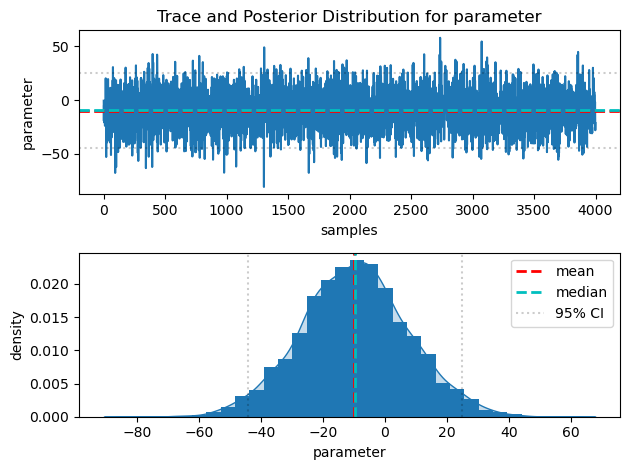

In [70]:
a1 = fit1["beta"][0].reshape(4000,)

plot_trace(a1)

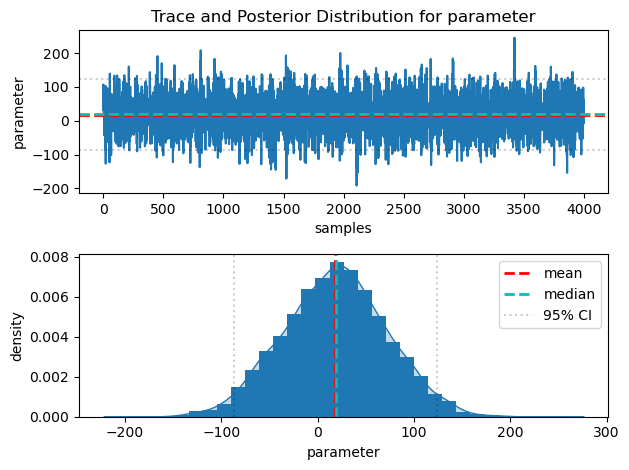

In [71]:
b1 = fit1["beta"][2].reshape(4000,)

plot_trace(b1)

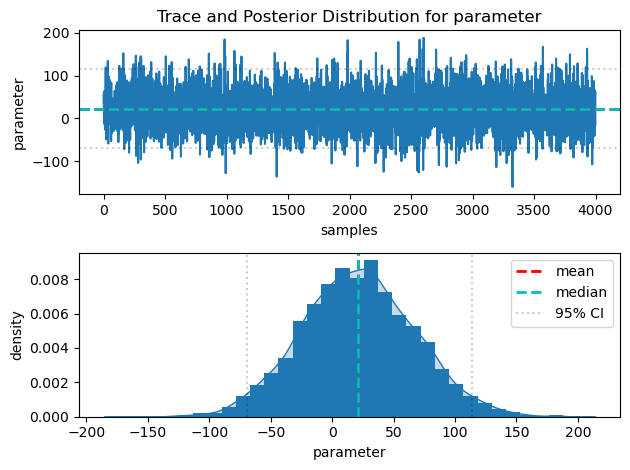

In [65]:
c1 = fit1["beta"][2].reshape(4000,)

plot_trace(c1)

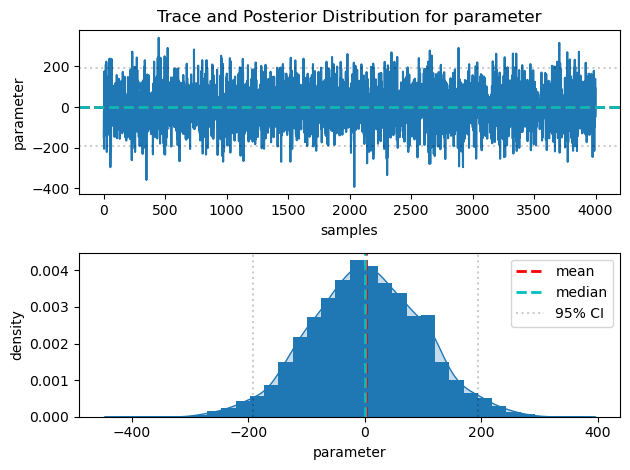

In [66]:
d1 = fit1["beta"][3].reshape(4000,)

plot_trace(d1)

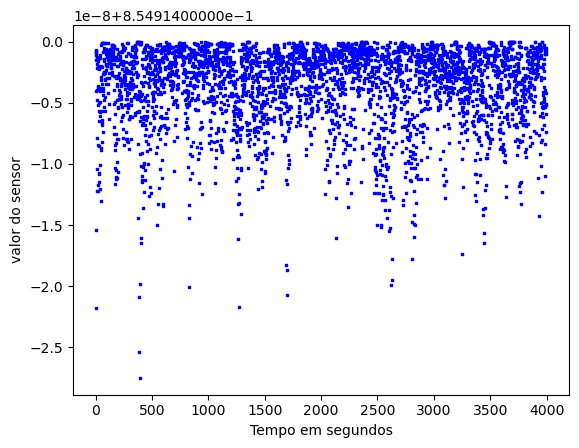

In [50]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(a, e, s=1, c='b', marker="s", label='5')

plt.xlabel("Tempo em segundos")
plt.ylabel("valor do sensor")
#ax1.hist(a, 30, density=True); 
#sns.kdeplot(e, shade=True)
# plt.savefig("dados corrigidos")

plt.show()

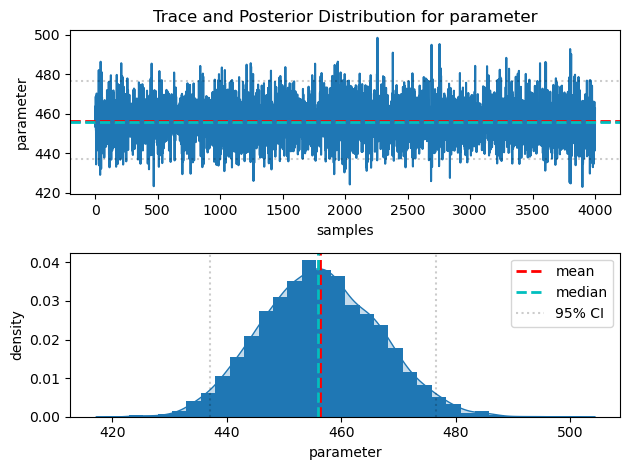

In [73]:
e1 = fit1["sigma"].reshape(4000,)

plot_trace(e1)

O resultado é estranhíssimo.
Agora com a ordenada:

In [12]:
# From: Bayesian Models for Astrophysical Data, Cambridge Univ. Press
# (c) 2017,  Joseph M. Hilbe, Rafael S. de Souza and Emille E. O. Ishida 
# 
# you are kindly asked to include the complete citation if you used this 
# material in a publication

# Code 4.7 - Multivariate normal linear model in Python using Stan
# 1 response (y) and 2 explanatory variables (x1, x2)

# ^^ a implementação foi inspirada no autor acima


import numpy as np
import statsmodels.api as sm
import stan
from scipy.stats import uniform, norm
import json
# Data
np.random.seed(1056)                 # set seed to replicate example
nobs= livro.shape[0]                         # number of obs in model 
x1 = livro['1'].to_numpy()          # random uniform variable
x2 = livro['2'].to_numpy()          # second explanatory
x3 = livro['3'].to_numpy()
x4 = livro['4'].to_numpy()

X = np.column_stack((x1,x2, x3, x4))        # create response matrix
# X = np.column_stack((x1, x2))
X = sm.add_constant(X)              # add intercept

y = livro['y'].to_numpy() # agora faz regressão na abcissa do centro de massa calculado do corpo de prova

# Fit
data = {}                                # build data dictionary
data['nobs'] = nobs                      # sample size
data['x'] = X                            # explanatory variable         
data['y'] = y                            # response variable
data['k'] = data['x'].shape[1]       # number of explanatory variables

# data = json.dumps(list(data))

# data = data.to_json()



# O QUE TA ACONTECENDO AAAAAAAAAAAAAAAAAAAAAAAAAAAAA




# STAN code
stan_code = """
data {
    int<lower=1> k;  
    int<lower=0> nobs;                                 
    matrix[nobs, k] x;                     
    vector[nobs] y;                     
}
parameters {
    matrix[k,1] beta;                                             
    real<lower=0> sigma;               
}
transformed parameters{
    matrix[nobs,1] mu;
    vector[nobs] mu2;

    mu = x * beta;
    mu2 = to_vector(mu);                 // normal distribution 
                                         // does not take matrices as input
}
model {
    for (i in 1:k){                      // Diffuse normal priors for predictors
        beta[i] ~ normal(0.0, 100);
    }
    sigma ~ uniform(1.007197 - 0.2, 1.007197 + 0.2);             // Uniform prior for standard deviation

    y ~ normal(mu2, sigma);              // Likelihood function
}
"""

# Compile model
model = stan.build(stan_code, data)

# perform fit
fit2 = model.sample(num_chains=4, num_samples=1000)


# Output
nlines = 9                                   # number of lines in screen output

output = str(fit2).split('\n')
for item in output[:nlines]:
    print(item)   

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_ywwbnour/model_dfuozmfw.stan', line 24, column 4: Parameter
    sigma is given a uniform distribution. The uniform distribution is not
    recommended, for two reasons: (a) Except when there are logical or
    physical constraints, it is very unusual for you to be sure that a
    parameter will fall inside a specified range, and (b) The infinite
    gradient induced by a uniform density can cause difficulties for Stan's
    sampling algorithm. As a consequence, we recommend soft constraints
    rather than hard constraints; for example, instead of giving an
    elasticity parameter a uniform(0,1) distribution, try normal(0.5,0.5).
Warning in '/tmp/httpstan_ywwbnour/model_dfuozmfw.stan', line 22, column 30: Argument
    100 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   6% (500/8000)
Sampling:  31% (2500

<stan.Fit>
Parameters:
    beta: (5, 1)
    sigma: ()
    mu: (704, 1)
    mu2: (704,)
Draws: 4000


In [38]:
a2

array([ 1.94802726,  1.71020623,  1.86177318, ...,  1.71020316,
        1.8617756 , -0.14682563])

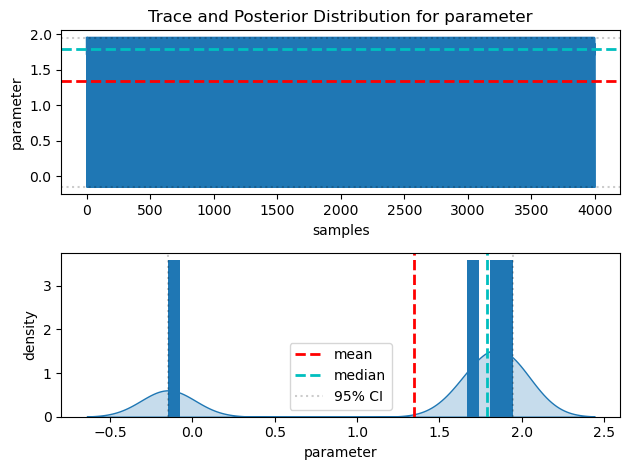

In [13]:
a2 = fit2["beta"][0].reshape(4000,)

plot_trace(a2)

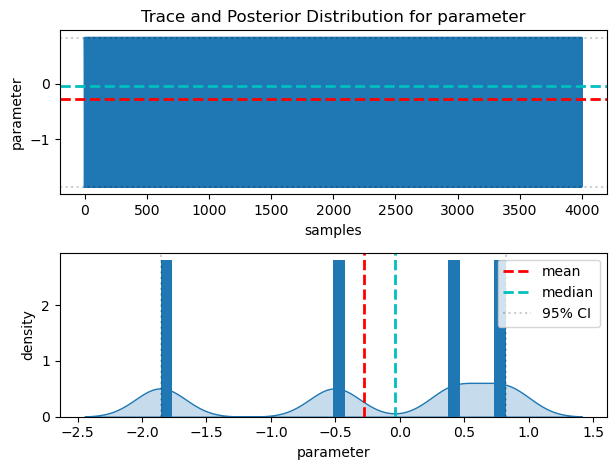

In [14]:
b2 = fit2["beta"][2].reshape(4000,)

plot_trace(b2)

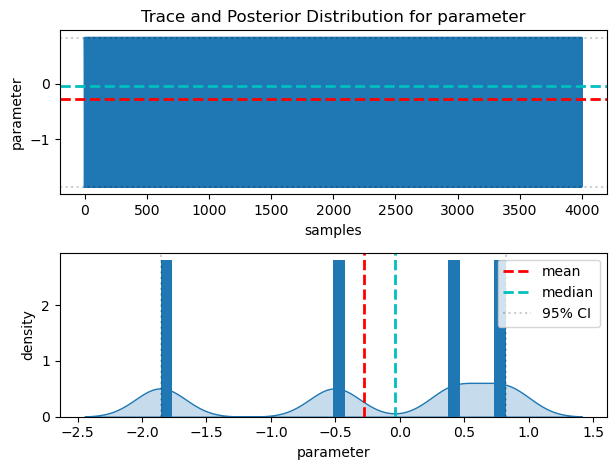

In [15]:
c2 = fit2["beta"][2].reshape(4000,)

plot_trace(c2)

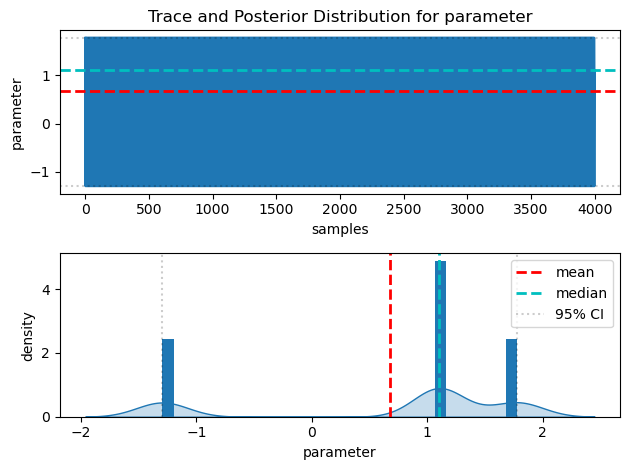

In [16]:
d2 = fit2["beta"][3].reshape(4000,)

plot_trace(d2)

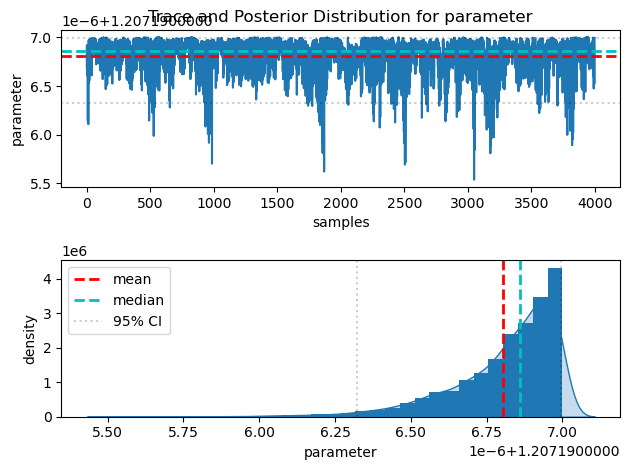

In [17]:
e2 = fit2["sigma"].reshape(4000,)

plot_trace(e2)

Interpretação dos parâmetros: